In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#### Preprocecing ###

In [3]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [4]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [5]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [6]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]

In [7]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]

In [8]:
removed = recovered + death

In [9]:
### Data Preparation ###

In [63]:
S = confirmed.values
R = removed.values
L = 7

In [64]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L':L, 'S': S, 'R': R}

In [65]:
### Model ###

In [66]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b3ec379b973d1619a9dd6f3c54e9e93 NOW.


In [67]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [68]:
### Simulation and Visualization functions ###

In [69]:
T = S.shape[0]
N = S.shape[1]

In [70]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start + pd.Timedelta(days=L-1)].values
    recovered = removed.loc[start + pd.Timedelta(days=L-1)].values
    infected_list = [confirmed.loc[d].values - removed.loc[d].values for d 
                     in pd.date_range(start, periods=L, freq='D')]
    for d in range(L, horizen):
        cumulative0 = cumulative
        r = 0
        for k in range(1,L+1):
            r += infected_list[-k] @ c[k-1]
        I = r * (1 - cumulative / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.maximum(I, 0)
        recovered = recovered + a * (cumulative0 - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.maximum(recovered, 0)
        infected_list.append(cumulative - recovered)
    infected = pd.DataFrame(infected_list, 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected

In [71]:
def draw_infected(fit, start, horizen, country):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data_list =[]
    for i in range(a.shape[0]):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.DataFrame({"infected":infected[country]})
        data['date'] = pd.date_range('2020-01-22', periods=horizen, freq='D')
        data_list.append(data)
    data = pd.concat(data_list)
    data['simulated'] = True
    data_real = pd.DataFrame({'infected':(confirmed - removed)[country]})
    data_real['simulated'] = False
    data = pd.concat([data, data_real])
    data['date'] = data.index
    data['days'] = (data['date'] - pd.to_datetime('2020-01-22')).apply(lambda x: x.days)
    sns.relplot(x="days", y="infected", hue="simulated", kind="line", ci='sd', data=data);

In [72]:
### Validation ###

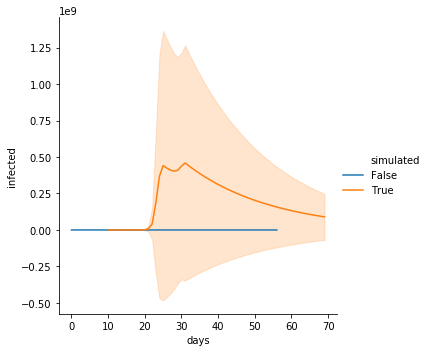

In [73]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

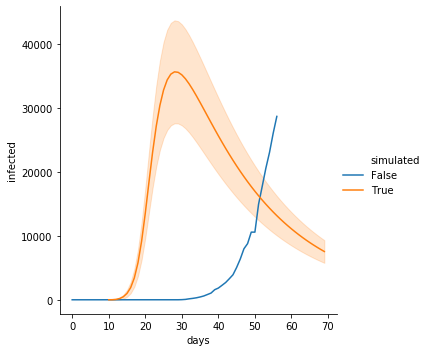

In [62]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'Italy')

In [ ]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'Norway')

In [ ]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'Korea, South')

In [ ]:
### Prediction ###

In [ ]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'China')

In [ ]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'Italy')

In [ ]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'Norway')

In [ ]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'Korea, South')